In [121]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fedcore.algorithm.low_rank.decomposer import (
    SVDDecomposition, RandomizedSVD, BasicRandomizedSVD,
    RPHOSVDDecomposition, RSTHOSVDDecomposition, RSTDecomposition
)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

torch.manual_seed(42)
np.random.seed(42)

In [122]:
def patched_get_stable_rank(self, min_num_samples, shape):
    return min_num_samples

RandomizedSVD._get_stable_rank = patched_get_stable_rank

In [123]:
def create_test_tensor(shape, tensor_type='random'):
    if tensor_type == 'random':
        return torch.randn(shape)
    elif tensor_type == 'low_rank':
        if len(shape) == 2:
            rank = min(shape) // 3
            U = torch.randn(shape[0], rank)
            V = torch.randn(rank, shape[1])
            return U @ V
        else:
            tensor = torch.zeros(shape)
            for i in range(min(shape)):
                if len(shape) == 3:
                    tensor[i, i, i] = 1.0
                elif len(shape) == 4:
                    tensor[i, i, i, i] = 1.0
            return tensor
    else:
        raise ValueError(f"Unknown tensor type: {tensor_type}")

def evaluate_matrix_decomposition(matrix, decomposer, **kwargs):
    decomposer_instance = decomposer(**kwargs)
    U, S, V = decomposer_instance.decompose(matrix)
    error = decomposer_instance.get_approximation_error(matrix, U, S, V)
    return error.item(), U.shape, S.shape, V.shape

def evaluate_tensor_decomposition(tensor, decomposer, **kwargs):
    decomposer_instance = decomposer(**kwargs)
    core, factors = decomposer_instance.decompose(tensor)
    error = decomposer_instance.get_approximation_error(tensor, core, factors)
    return error.item(), core.shape, [f.shape for f in factors]


In [124]:
print("=== Test BasicRandomizedSVD vs RandomizedSVD ===")

matrix_shapes = [(30, 15), (50, 40), (100, 80)]
ranks = [3, 5, 10]

results_basic_vs_randomized = []

original_get_stable_rank = RandomizedSVD._get_stable_rank
def fixed_get_stable_rank(self, W):
    n_samples = max(W.shape)
    min_num_samples = johnson_lindenstrauss_min_dim(n_samples, eps=self.distortion_factors).tolist()
    return min(round(min_num_samples), max(W.size()), 1)

RandomizedSVD._get_stable_rank = fixed_get_stable_rank

try:
    for shape in matrix_shapes:
        for rank in ranks:
            if rank <= min(shape):
                matrix = create_test_tensor(shape, 'low_rank')
                
                # BasicRandomizedSVD
                error_basic, U_shape, S_shape, V_shape = evaluate_matrix_decomposition(
                    matrix, BasicRandomizedSVD, target_rank=rank
                )
                
                # RandomizedSVD
                error_randomized, U_shape_r, S_shape_r, V_shape_r = evaluate_matrix_decomposition(
                    matrix, RandomizedSVD, power=3, distortion_factor=0.6
                )
                
                results_basic_vs_randomized.append({
                    'shape': shape,
                    'rank': rank,
                    'basic_error': error_basic,
                    'randomized_error': error_randomized,
                    'improvement': error_randomized / error_basic if error_basic > 0 else 1.0
                })
                
                print(f"Matrix {shape}, rank {rank}:")
                print(f"  BasicRandomizedSVD: {error_basic:.6f}")
                print(f"  RandomizedSVD: {error_randomized:.6f}")
                print(f"  Improvement: {error_randomized/error_basic:.2f}x")

finally:
    RandomizedSVD._get_stable_rank = original_get_stable_rank

print(f"\nTested {len(results_basic_vs_randomized)} combinations")

=== Test BasicRandomizedSVD vs RandomizedSVD ===
Matrix (30, 15), rank 3:
  BasicRandomizedSVD: 30.048489
  RandomizedSVD: 36.396698
  Improvement: 1.21x
Matrix (30, 15), rank 5:
  BasicRandomizedSVD: 30.883324
  RandomizedSVD: 41.950531
  Improvement: 1.36x
Matrix (30, 15), rank 10:
  BasicRandomizedSVD: 20.172775
  RandomizedSVD: 43.316025
  Improvement: 2.15x
Matrix (50, 40), rank 3:
  BasicRandomizedSVD: 134.857239
  RandomizedSVD: 148.991165
  Improvement: 1.10x
Matrix (50, 40), rank 5:
  BasicRandomizedSVD: 109.150993
  RandomizedSVD: 145.425446
  Improvement: 1.33x
Matrix (50, 40), rank 10:
  BasicRandomizedSVD: 98.146339
  RandomizedSVD: 158.295959
  Improvement: 1.61x
Matrix (100, 80), rank 3:
  BasicRandomizedSVD: 400.534698
  RandomizedSVD: 429.425903
  Improvement: 1.07x
Matrix (100, 80), rank 5:
  BasicRandomizedSVD: 387.982819
  RandomizedSVD: 438.671814
  Improvement: 1.13x
Matrix (100, 80), rank 10:
  BasicRandomizedSVD: 337.242279
  RandomizedSVD: 443.906708
  Improvem

C:\Users\Bars\AppData\Local\Temp\ipykernel_29824\3971795943.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(errors_data, labels=['BasicRandomizedSVD', 'RandomizedSVD'])


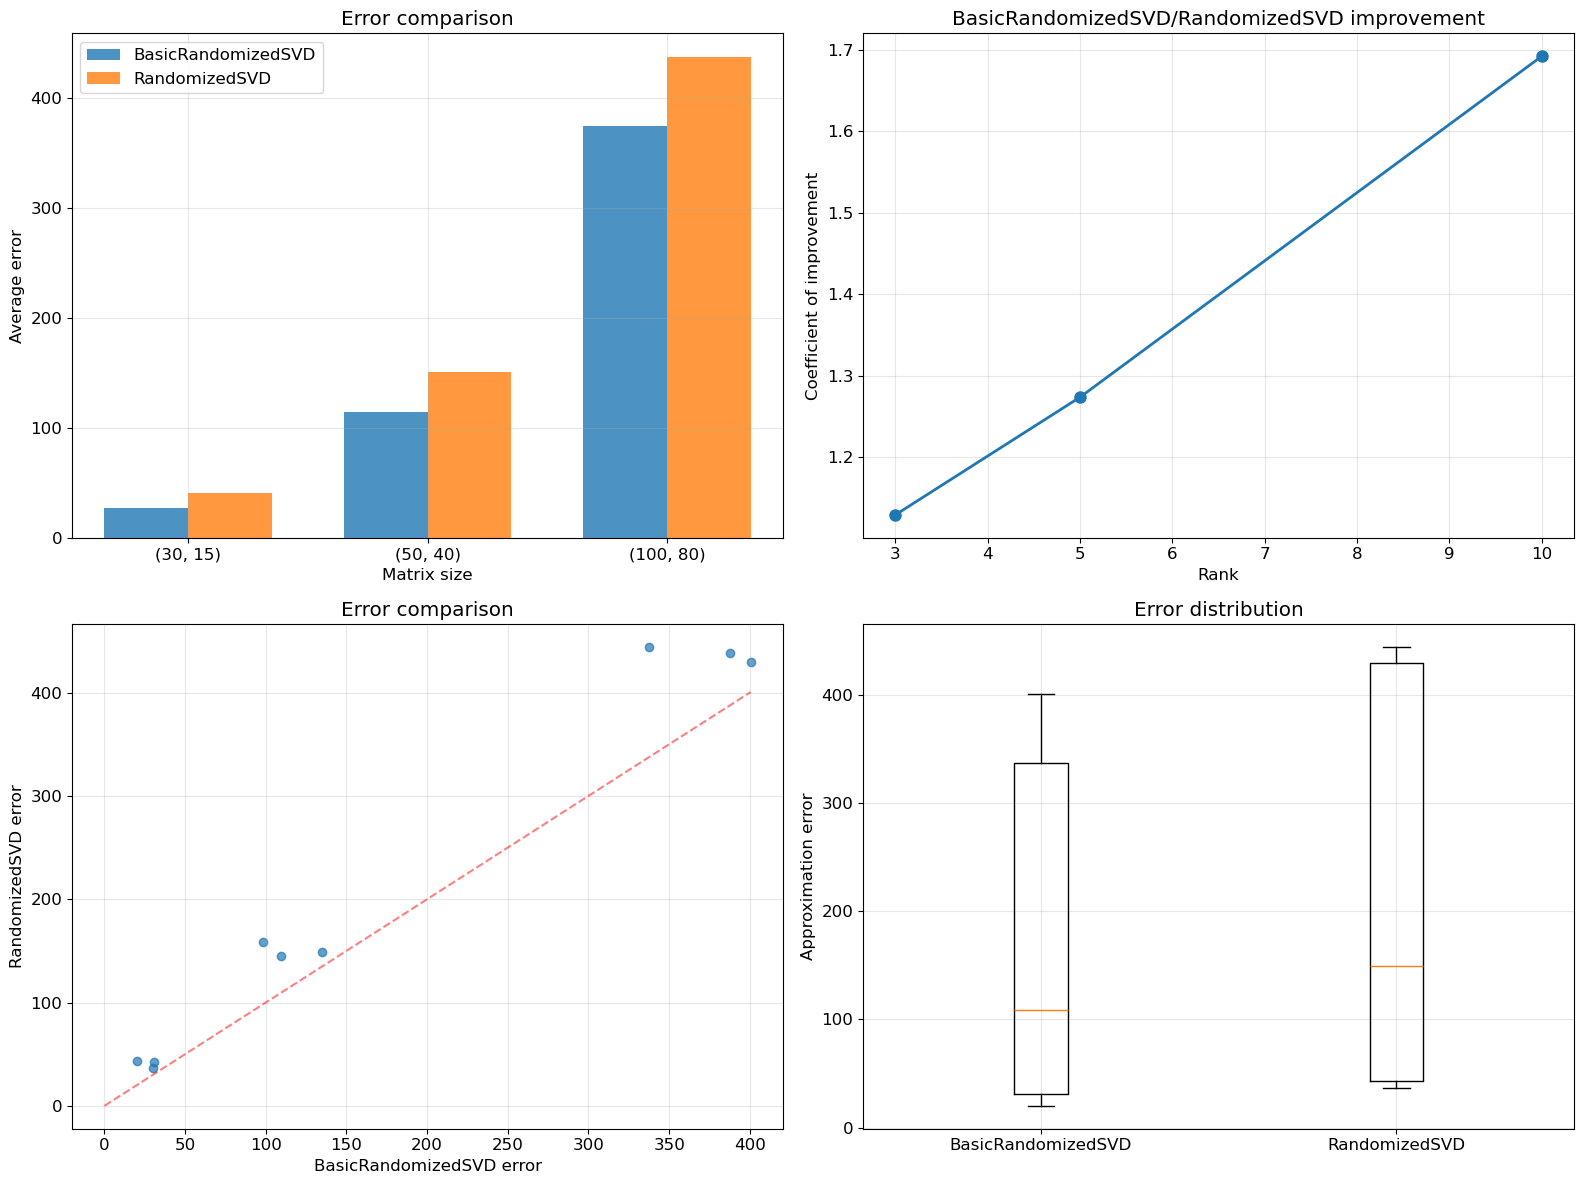

Average error BasicRandomizedSVD: 172.113217
Average error RandomizedSVD: 209.597805
Average improvement: 1.37x


In [125]:
df_basic_vs_randomized = pd.DataFrame(results_basic_vs_randomized)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

shapes = df_basic_vs_randomized['shape'].unique()
x = np.arange(len(shapes))
width = 0.35

basic_errors = [df_basic_vs_randomized[df_basic_vs_randomized['shape'] == shape]['basic_error'].mean() for shape in shapes]
randomized_errors = [df_basic_vs_randomized[df_basic_vs_randomized['shape'] == shape]['randomized_error'].mean() for shape in shapes]

ax1.bar(x - width/2, basic_errors, width, label='BasicRandomizedSVD', alpha=0.8)
ax1.bar(x + width/2, randomized_errors, width, label='RandomizedSVD', alpha=0.8)
ax1.set_xlabel('Matrix size')
ax1.set_ylabel('Average error')
ax1.set_title('Error comparison')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{shape}" for shape in shapes])
ax1.legend()
ax1.grid(True, alpha=0.3)

ranks = df_basic_vs_randomized['rank'].unique()
improvements = [df_basic_vs_randomized[df_basic_vs_randomized['rank'] == rank]['improvement'].mean() for rank in ranks]

ax2.plot(ranks, improvements, marker='o', linewidth=2, markersize=8)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Coefficient of improvement')
ax2.set_title('BasicRandomizedSVD/RandomizedSVD improvement')
ax2.grid(True, alpha=0.3)

ax3.scatter(df_basic_vs_randomized['basic_error'], df_basic_vs_randomized['randomized_error'], alpha=0.7)
ax3.plot([0, max(df_basic_vs_randomized['basic_error'])], [0, max(df_basic_vs_randomized['basic_error'])], 'r--', alpha=0.5)
ax3.set_xlabel('BasicRandomizedSVD error')
ax3.set_ylabel('RandomizedSVD error')
ax3.set_title('Error comparison')
ax3.grid(True, alpha=0.3)

# 4. Box plot распределения ошибок
errors_data = [df_basic_vs_randomized['basic_error'], df_basic_vs_randomized['randomized_error']]
box_plot = ax4.boxplot(errors_data, labels=['BasicRandomizedSVD', 'RandomizedSVD'])
ax4.set_ylabel('Approximation error')
ax4.set_title('Error distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print(f"Average error BasicRandomizedSVD: {df_basic_vs_randomized['basic_error'].mean():.6f}")
print(f"Average error RandomizedSVD: {df_basic_vs_randomized['randomized_error'].mean():.6f}")
print(f"Average improvement: {df_basic_vs_randomized['improvement'].mean():.2f}x")

In [126]:
def create_test_tensor(shape, rank_type='low'):
    if rank_type == 'low':
        rank = min(3, min(shape))
        if len(shape) == 2:
            U = torch.randn(shape[0], rank)
            S = torch.randn(rank)
            V = torch.randn(rank, shape[1])
            tensor = U @ torch.diag(S) @ V
        else:
            tensor = torch.zeros(shape)
            for _ in range(rank):
                factor = torch.ones(1)
                for dim in shape:
                    factor = factor.unsqueeze(-1) * torch.randn(dim).unsqueeze(0)
                tensor = tensor + factor
            if tensor.dim() > len(shape):
                tensor = tensor.squeeze(0)
        tensor = tensor + 0.01 * torch.randn_like(tensor)
    elif rank_type == 'random':
        tensor = torch.randn(shape)
    return tensor

def evaluate_approximation_quality(original_tensor, core_tensor, factor_matrices):
    original_norm = torch.linalg.norm(original_tensor)
    core_norm = torch.linalg.norm(core_tensor)
    relative_error = torch.abs(original_norm - core_norm) / original_norm

    original_size = original_tensor.numel()
    core_size = core_tensor.numel()
    factor_sizes = sum(factor.numel() for factor in factor_matrices)
    total_compressed_size = core_size + factor_sizes
    compression_ratio = original_size / total_compressed_size

    return {
        'relative_error': relative_error.item(),
        'compression_ratio': compression_ratio,
        'original_norm': original_norm.item(),
        'core_norm': core_norm.item(),
        'original_size': original_size,
        'core_size': core_size,
        'factor_size': factor_sizes,
        'total_compressed_size': total_compressed_size
    }

In [130]:
print("RP-HOSVD/SVD matrix comparison")
print("=" * 50)

matrix = create_test_tensor((200, 120), 'low')
print(f"Test matrix: {matrix.shape}")

rphosvd = RPHOSVDDecomposition(rank=4)
core_tensor, factor_matrices = rphosvd.decompose(matrix)
quality_rphosvd = evaluate_approximation_quality(matrix, core_tensor, factor_matrices)

print("\n=== Quality evaluation for RP-HOSVD ===")
print(f"Norm Relative Error: {quality_rphosvd['relative_error']:.6f}")
print(f"Compression ratio: {quality_rphosvd['compression_ratio']:.2f}x")
print(f"  Original size: {quality_rphosvd['original_size']}")
print(f"  Total Compressed Size: {quality_rphosvd['total_compressed_size']}")
print(f"Core ranks: {core_tensor.shape}")
for i, factor in enumerate(factor_matrices):
    print(f"  Factor {i+1}: {factor.shape}")

svd = SVDDecomposition()
U, S, Vh = svd.decompose(matrix)
S_truncated = S.clone()
S_truncated[5:] = 0
reconstructed = (U * S_truncated) @ Vh
svd_error = torch.linalg.norm(matrix - reconstructed) / torch.linalg.norm(matrix)
svd_compression = matrix.numel() / (U.shape[0] * 5 + 5 + Vh.shape[1] * 5)

print("\n=== SVD quality evaluation ===")
print(f"SVD Relative Error: {svd_error:.6f}")
print(f"SVD Compression ratio: {svd_compression:.2f}x")

print("\n=== Comparison ===")
print(f"RP-HOSVD error: {quality_rphosvd['relative_error']:.6f}")
print(f"SVD error: {svd_error:.6f}")
print(f"RP-HOSVD compression: {quality_rphosvd['compression_ratio']:.2f}x")
print(f"SVD compression: {svd_compression:.2f}x")

matrix_results = {
    'RP-HOSVD': {'error': quality_rphosvd['relative_error'], 'compression': quality_rphosvd['compression_ratio']},
    'SVD': {'error': svd_error, 'compression': svd_compression}
}

RP-HOSVD/SVD matrix comparison
Test matrix: torch.Size([200, 120])

=== Quality evaluation for RP-HOSVD ===
Norm Relative Error: 0.000031
Compression ratio: 18.52x
  Original size: 24000
  Total Compressed Size: 1296
Core ranks: torch.Size([4, 4])
  Factor 1: torch.Size([120, 4])
  Factor 2: torch.Size([200, 4])

=== SVD quality evaluation ===
SVD Relative Error: 0.005455
SVD Compression ratio: 14.95x

=== Comparison ===
RP-HOSVD error: 0.000031
SVD error: 0.005455
RP-HOSVD compression: 18.52x
SVD compression: 14.95x


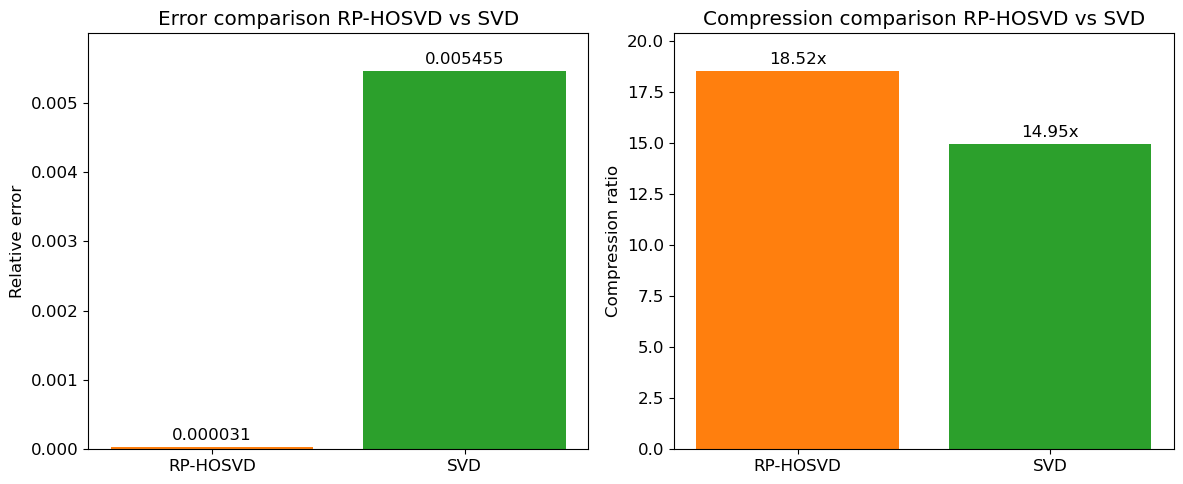

RP-HOSVD better than SVD in 176.0 times by accuracy


In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

methods = list(matrix_results.keys())
errors = [matrix_results[m]['error'] for m in methods]
compressions = [matrix_results[m]['compression'] for m in methods]

ax1.bar(methods, errors, color=['#ff7f0e', '#2ca02c'])
ax1.set_ylabel('Relative error')
ax1.set_title('Error comparison RP-HOSVD vs SVD')
ax1.set_ylim(0, max(errors) * 1.1)

for i, v in enumerate(errors):
    ax1.text(i, v + max(errors) * 0.01, f'{v:.6f}', ha='center', va='bottom')

ax2.bar(methods, compressions, color=['#ff7f0e', '#2ca02c'])
ax2.set_ylabel('Compression ratio')
ax2.set_title('Compression comparison RP-HOSVD vs SVD')
ax2.set_ylim(0, max(compressions) * 1.1)

for i, v in enumerate(compressions):
    ax2.text(i, v + max(compressions) * 0.01, f'{v:.2f}x', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"RP-HOSVD better than SVD in {svd_error / quality_rphosvd['relative_error']:.1f} times by accuracy")

In [147]:
print("Testing on different types of tensors")
print("=" * 50)

tensor_types = [
    ((30, 40, 50), 'low', 'Low-rank tensor'),
    ((50, 60, 70), 'random', 'Random tensor'),
    ((100, 80, 60), 'low', 'Big low-rank tensor'),
]

tensor_results = []

for shape, tensor_type, description in tensor_types:
    print(f"\n--- {description} {shape} ---")
    tensor = create_test_tensor(shape, tensor_type)
    
    # Формируем ранги в зависимости от размерности
    if len(shape) == 4:
        ranks_list = [
            [min(shape[0], 10), min(shape[1], 10), min(shape[2], 10), min(shape[3], 10)],
            [min(shape[0], 20), min(shape[1], 20), min(shape[2], 20), min(shape[3], 20)],
        ]
    else:
        ranks_list = [
            [min(shape[0], 10), min(shape[1], 10), min(shape[2], 10)],
            [min(shape[0], 20), min(shape[1], 20), min(shape[2], 20)],
        ]

    for ranks in ranks_list:
        print(f"  Ranks: {ranks}")
        rphosvd = RPHOSVDDecomposition(rank=ranks)
        core_tensor, factor_matrices = rphosvd.decompose(tensor)
        quality = evaluate_approximation_quality(tensor, core_tensor, factor_matrices)

        print(f"\n=== Quality Assessment for RP-HOSVD (ranks {ranks}) ===")
        print(f"Relative error by norm: {quality['relative_error']:.6f}")
        print(f"Compression ratio: {quality['compression_ratio']:.2f}x")
        print(f"  Original size: {quality['original_size']}")
        print(f"  Total compressed size: {quality['total_compressed_size']}")
        print(f"Core ranks: {core_tensor.shape}")
        for i, factor in enumerate(factor_matrices):
            print(f"  Factor {i+1}: {factor.shape}")
        
        tensor_results.append({
            'description': description,
            'shape': shape,
            'ranks': ranks,
            'error': quality['relative_error'],
            'compression': quality['compression_ratio'],
            'core_shape': core_tensor.shape
        })

Testing on different types of tensors

--- Low-rank tensor (30, 40, 50) ---
  Ranks: [10, 10, 10]

=== Quality Assessment for RP-HOSVD (ranks [10, 10, 10]) ===
Relative error by norm: 0.000013
Compression ratio: 2.93x
  Original size: 60000
  Total compressed size: 20500
Core ranks: torch.Size([10, 10])
  Factor 1: torch.Size([2000, 10])
  Factor 2: torch.Size([30, 10])
  Factor 3: torch.Size([10, 10])
  Ranks: [20, 20, 20]

=== Quality Assessment for RP-HOSVD (ranks [20, 20, 20]) ===
Relative error by norm: 0.000005
Compression ratio: 1.45x
  Original size: 60000
  Total compressed size: 41400
Core ranks: torch.Size([20, 20])
  Factor 1: torch.Size([2000, 20])
  Factor 2: torch.Size([30, 20])
  Factor 3: torch.Size([20, 20])

--- Random tensor (50, 60, 70) ---
  Ranks: [10, 10, 10]

=== Quality Assessment for RP-HOSVD (ranks [10, 10, 10]) ===
Relative error by norm: 0.551633
Compression ratio: 4.92x
  Original size: 210000
  Total compressed size: 42700
Core ranks: torch.Size([10, 10]

C:\Users\Bars\AppData\Local\Temp\ipykernel_29824\752228945.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df.iloc[[0,1,4,5]][df['description'] == desc]
C:\Users\Bars\AppData\Local\Temp\ipykernel_29824\752228945.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df.iloc[[0,1,4,5]][df['description'] == desc]
C:\Users\Bars\AppData\Local\Temp\ipykernel_29824\752228945.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df.iloc[[0,1,4,5]][df['description'] == desc]


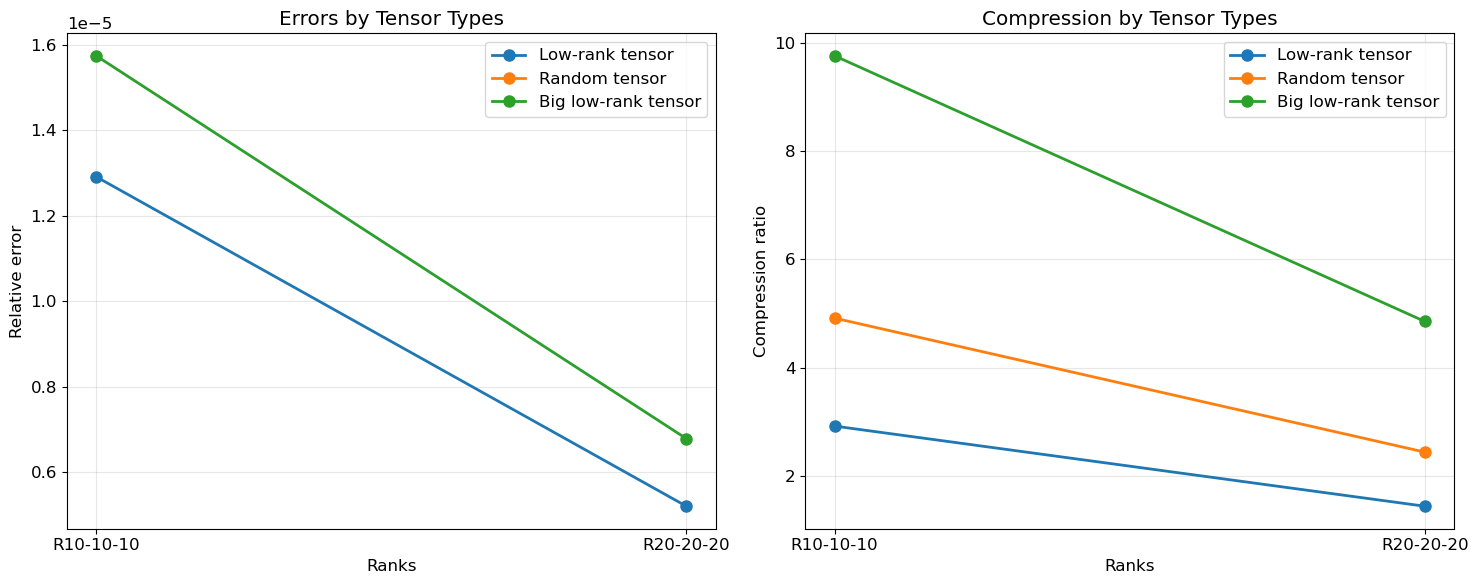


Results table:
        description         shape        ranks    error  compression
    Low-rank tensor  (30, 40, 50) [10, 10, 10] 0.000013     2.926829
    Low-rank tensor  (30, 40, 50) [20, 20, 20] 0.000005     1.449275
      Random tensor  (50, 60, 70) [10, 10, 10] 0.551633     4.918033
      Random tensor  (50, 60, 70) [20, 20, 20] 0.365021     2.447552
Big low-rank tensor (100, 80, 60) [10, 10, 10] 0.000016     9.756098
Big low-rank tensor (100, 80, 60) [20, 20, 20] 0.000007     4.858300


In [151]:
df = pd.DataFrame(tensor_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

descriptions = df['description'].unique()
for desc in descriptions:
    subset = df.iloc[[0,1,4,5]][df['description'] == desc]
    ranks_str = [f"R{'-'.join(map(str, r))}" for r in subset['ranks']]
    ax1.plot(ranks_str, subset['error'], 'o-', label=desc, linewidth=2, markersize=8)

ax1.set_xlabel('Ranks')
ax1.set_ylabel('Relative error')
ax1.set_title('Errors by Tensor Types')
ax1.legend()
ax1.grid(True, alpha=0.3)

for desc in descriptions:
    subset = df[df['description'] == desc]
    ranks_str = [f"R{'-'.join(map(str, r))}" for r in subset['ranks']]
    ax2.plot(ranks_str, subset['compression'], 'o-', label=desc, linewidth=2, markersize=8)

ax2.set_xlabel('Ranks')
ax2.set_ylabel('Compression ratio')
ax2.set_title('Compression by Tensor Types')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResults table:")
print(df[['description', 'shape', 'ranks', 'error', 'compression']].to_string(index=False))

In [141]:
print("Convergence testing")
print("=" * 50)

tensor = create_test_tensor((80, 60, 40), 'low')
print(f"Test tensor: {tensor.shape}")

ranks_list = [
    [3, 3, 3],
    [4, 4, 4],
    [5, 5, 5],
    [6, 6, 8],
]

convergence_results = []

for ranks in ranks_list:
    print(f"\n--- Ranks {ranks} ---")
    rphosvd = RPHOSVDDecomposition(rank=ranks)
    core_tensor, factor_matrices = rphosvd.decompose(tensor)
    quality = evaluate_approximation_quality(tensor, core_tensor, factor_matrices)
    
    convergence_results.append({
        'ranks': ranks,
        'error': quality['relative_error'],
        'compression': quality['compression_ratio'],
        'core_shape': core_tensor.shape
    })

    print(f"\n=== Quality Assessment for RP-HOSVD (ранги {ranks}) ===")
    print(f"Relative error by norm: {quality['relative_error']:.6f}")
    print(f"Compression ratio: {quality['compression_ratio']:.2f}x")
    print(f"  Original size: {quality['original_size']}")
    print(f"  Total compressed size: {quality['total_compressed_size']}")
    print(f"Core ranks: {core_tensor.shape}")
    for i, factor in enumerate(factor_matrices):
        print(f"  Factor {i+1}: {factor.shape}")

print(f"\n=== Convergence results ===")
for result in convergence_results:
    print(f"Ranks {result['ranks']}: error {result['error']:.6f}, compression {result['compression']:.2f}x")

Convergence testing
Test tensor: torch.Size([80, 60, 40])

--- Ranks [3, 3, 3] ---

=== Quality Assessment for RP-HOSVD (ранги [3, 3, 3]) ===
Relative error by norm: 0.000476
Compression ratio: 25.74x
  Original size: 192000
  Total compressed size: 7458
Core ranks: torch.Size([3, 3])
  Factor 1: torch.Size([2400, 3])
  Factor 2: torch.Size([80, 3])
  Factor 3: torch.Size([3, 3])

--- Ranks [4, 4, 4] ---

=== Quality Assessment for RP-HOSVD (ранги [4, 4, 4]) ===
Relative error by norm: 0.000095
Compression ratio: 19.29x
  Original size: 192000
  Total compressed size: 9952
Core ranks: torch.Size([4, 4])
  Factor 1: torch.Size([2400, 4])
  Factor 2: torch.Size([80, 4])
  Factor 3: torch.Size([4, 4])

--- Ranks [5, 5, 5] ---

=== Quality Assessment for RP-HOSVD (ранги [5, 5, 5]) ===
Relative error by norm: 0.000051
Compression ratio: 15.42x
  Original size: 192000
  Total compressed size: 12450
Core ranks: torch.Size([5, 5])
  Factor 1: torch.Size([2400, 5])
  Factor 2: torch.Size([80, 5

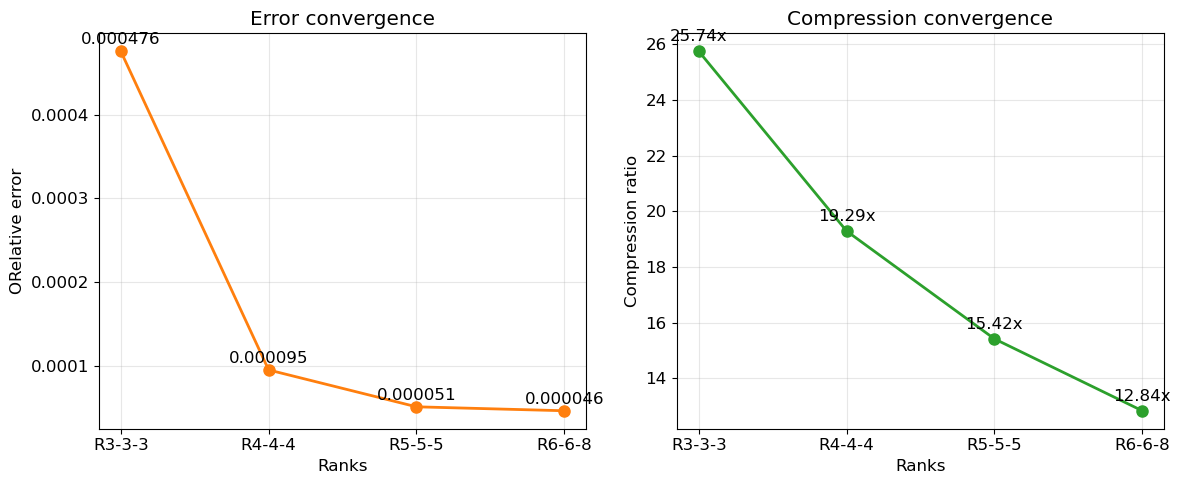

Error improvement: 10.37x


In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ranks_str = [f"R{'-'.join(map(str, r))}" for r in [r['ranks'] for r in convergence_results]]
errors = [r['error'] for r in convergence_results]
compressions = [r['compression'] for r in convergence_results]

ax1.plot(ranks_str, errors, 'o-', color='#ff7f0e', linewidth=2, markersize=8)
ax1.set_xlabel('Ranks')
ax1.set_ylabel('ОRelative error')
ax1.set_title('Error convergence')
ax1.grid(True, alpha=0.3)

# Добавляем значения на точки
for i, (x, y) in enumerate(zip(ranks_str, errors)):
    ax1.text(x, y + max(errors) * 0.01, f'{y:.6f}', ha='center', va='bottom')

# График сжатия
ax2.plot(ranks_str, compressions, 'o-', color='#2ca02c', linewidth=2, markersize=8)
ax2.set_xlabel('Ranks')
ax2.set_ylabel('Compression ratio')
ax2.set_title('Compression convergence')
ax2.grid(True, alpha=0.3)

# Добавляем значения на точки
for i, (x, y) in enumerate(zip(ranks_str, compressions)):
    ax2.text(x, y + max(compressions) * 0.01, f'{y:.2f}x', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Анализ улучшения
if len(errors) > 1:
    improvement = errors[0] / errors[-1]
    print(f"Error improvement: {improvement:.2f}x")

In [144]:
random_matrix = create_random_matrix((50, 40))
random_tensor = create_random_tensor((15, 12, 10))

print("=== Random data comparison ===")

print("\nMatrix Algorithms:")
matrix_results = {}

original_get_stable_rank = RandomizedSVD._get_stable_rank
def fixed_get_stable_rank(self, W):
    n_samples = max(W.shape)
    min_num_samples = johnson_lindenstrauss_min_dim(n_samples, eps=self.distortion_factors).tolist()
    return min(round(min_num_samples), max(W.size()), 1)

RandomizedSVD._get_stable_rank = fixed_get_stable_rank

try:
    error, U_shape, S_shape, V_shape = evaluate_matrix_decomposition(
        random_matrix, RandomizedSVD, power=3, distortion_factor=0.6
    )
    matrix_results['RandomizedSVD'] = error
    print(f"RandomizedSVD: error {error:.6f}")
finally:
    RandomizedSVD._get_stable_rank = original_get_stable_rank

error, U_shape, S_shape, V_shape = evaluate_matrix_decomposition(
    random_matrix, BasicRandomizedSVD, target_rank=10
)
matrix_results['BasicRandomizedSVD'] = error
print(f"BasicRandomizedSVD: error {error:.6f}")

print("\nTensor algorithms:")
tensor_results = {}

# RPHOSVD
error, core_shape, factor_shapes = evaluate_tensor_decomposition(
    random_tensor, RPHOSVDDecomposition, rank=[5, 4, 3]
)
tensor_results['RPHOSVD'] = error
print(f"RPHOSVD: error {error:.6f}")

# RSTHOSVD
error, core_shape, factor_shapes = evaluate_tensor_decomposition(
    random_tensor, RSTHOSVDDecomposition, rank=[5, 4, 3]
)
tensor_results['RSTHOSVD'] = error
print(f"RSTHOSVD: error {error:.6f}")

# RST
error, core_shape, factor_shapes = evaluate_tensor_decomposition(
    random_tensor, RSTDecomposition, rank=[5, 4, 3], sampling_method='norm_based'
)
tensor_results['RST'] = error
print(f"RST: error {error:.6f}")

=== Random data comparison ===

Matrix Algorithms:
RandomizedSVD: error 41.790382
BasicRandomizedSVD: error 30.703770

Tensor algorithms:
RPHOSVD: error 21.817717
RSTHOSVD: error 18.349512
RST: error 40.927681


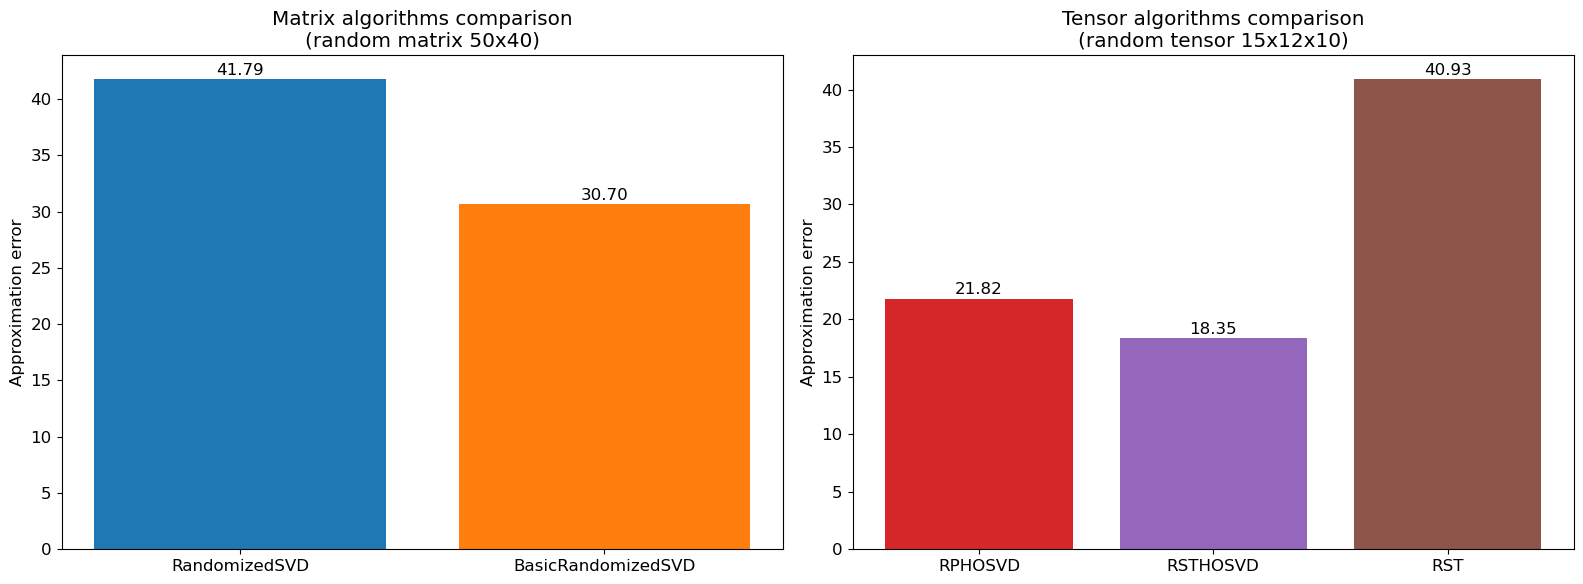

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

matrix_names = list(matrix_results.keys())
matrix_errors = list(matrix_results.values())
bars1 = ax1.bar(matrix_names, matrix_errors, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('Matrix algorithms comparison\n(random matrix 50x40)')
ax1.set_ylabel('Approximation error')
for bar, value in zip(bars1, matrix_errors):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
              f'{value:.2f}', ha='center', va='bottom')

tensor_names = list(tensor_results.keys())
tensor_errors = list(tensor_results.values())
bars2 = ax2.bar(tensor_names, tensor_errors, color=['#d62728', '#9467bd', '#8c564b'])
ax2.set_title('Tensor algorithms comparison\n(random tensor 15x12x10)')
ax2.set_ylabel('Approximation error')
for bar, value in zip(bars2, tensor_errors):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
              f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

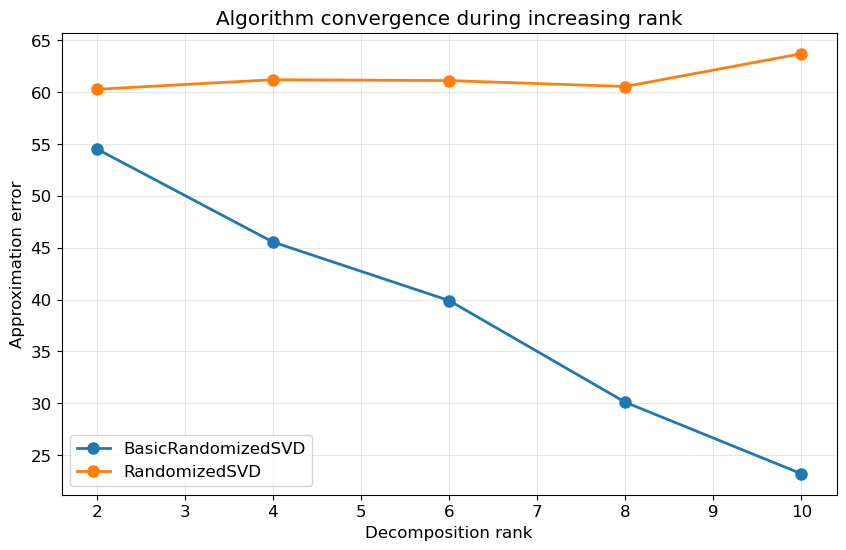

In [152]:
matrix = create_low_rank_matrix((30, 25), 8)
ranks = [2, 4, 6, 8, 10]

convergence_data = {}

convergence_data['BasicRandomizedSVD'] = []
for rank in ranks:
    error, _, _, _ = evaluate_matrix_decomposition(
        matrix, BasicRandomizedSVD, target_rank=rank
    )
    convergence_data['BasicRandomizedSVD'].append(error)

convergence_data['RandomizedSVD'] = []
original_get_stable_rank = RandomizedSVD._get_stable_rank
def fixed_get_stable_rank(self, W):
    n_samples = max(W.shape)
    min_num_samples = johnson_lindenstrauss_min_dim(n_samples, eps=self.distortion_factors).tolist()
    return min(round(min_num_samples), max(W.size()), 1)

RandomizedSVD._get_stable_rank = fixed_get_stable_rank

try:
    for rank in ranks:
        error, _, _, _ = evaluate_matrix_decomposition(
            matrix, RandomizedSVD, power=3, distortion_factor=0.6
        )
        convergence_data['RandomizedSVD'].append(error)
finally:
    RandomizedSVD._get_stable_rank = original_get_stable_rank

plt.figure(figsize=(10, 6))
for algo_name, errors in convergence_data.items():
    plt.plot(ranks, errors, marker='o', label=algo_name, linewidth=2, markersize=8)

plt.xlabel('Decomposition rank')
plt.ylabel('Approximation error')
plt.title('Algorithm convergence during increasing rank')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()